<a href="https://colab.research.google.com/github/danielamattos/Projetos---Master-Data-Decision-Science/blob/main/Atividade_Regress%C3%A3o_Log%C3%ADstica2(Machine_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Logística Multinomial

Para esta atividade usaremos um conjunto de dados sobre métricas do coração de pacientes, com o objetivo de determinar se o paciente é normal, suspeito ou com doença patológica. O conjunto de dado pode ser encontrado no [GitHub](https://raw.githubusercontent.com/bkrai/R-files-from-YouTube/main/Cardiotocographic.csv) de alguns usuários.

Abaixo encontra-se o dicionário de dados:

* LB: baseline value (SisPorto)
* AC: accelerations (SisPorto)
* FM: foetal movement (SisPorto)
* UC: uterine contractions (SisPorto)
* DL: light decelerations
* DS: severe decelerations
* DP: prolongued decelerations
* ASTV: percentage of time with abnormal short term variability (SisPorto)
* mSTV: mean value of short term variability (SisPorto)
* ALTV: percentage of time with abnormal long term variability (SisPorto)
* mLTV: mean value of long term variability (SisPorto)
* Width: histogram width
* Min: low freq. of the histogram
* Max: high freq. of the histogram
* Nmax: number of histogram peaks
* Nzeros: number of histogram zeros
* Mode: histogram mode
* Mean: histogram mean
* Median: histogram median
* Variance: histogram variance
* Tendency: histogram tendency: -1=left assymetric; 0=symmetric; 1=right assymetric
* NSP: Normal=0; Suspect=1; Pathologic=2


O objetivo é entender/prever a variável `NSP` em função das demais.

Obs: Não se preocupe se não entender o significado de cada variável, estamos lidando com um problema técnico e provavelmente você não terá um especialista na área e nem tempo suficiente para entender sobre a área de negócio para este exercício. Foque na construção do modelo de regressão logística.

## Atividade 1: Importe o conjunto de dados, verifique se há dados faltantes e a correlação entre as variáveis.

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/sirius/cardio.xlsx')

df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120,0.000000,0.0,0.000000,0.000000,0.0,0.0,73,0.5,43,...,62,126,2,0,120,137,121,73,1,1
1,132,0.006380,0.0,0.006380,0.003190,0.0,0.0,17,2.1,0,...,68,198,6,1,141,136,140,12,0,0
2,133,0.003322,0.0,0.008306,0.003322,0.0,0.0,16,2.1,0,...,68,198,5,1,141,135,138,13,0,0
3,134,0.002561,0.0,0.007682,0.002561,0.0,0.0,16,2.4,0,...,53,170,11,0,137,134,137,13,1,0
4,132,0.006515,0.0,0.008143,0.000000,0.0,0.0,16,2.4,0,...,53,170,9,0,137,136,138,11,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   int64  
 1   AC        2126 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   DL        2126 non-null   float64
 5   DS        2126 non-null   float64
 6   DP        2126 non-null   float64
 7   ASTV      2126 non-null   int64  
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   int64  
 10  MLTV      2126 non-null   float64
 11  Width     2126 non-null   int64  
 12  Min       2126 non-null   int64  
 13  Max       2126 non-null   int64  
 14  Nmax      2126 non-null   int64  
 15  Nzeros    2126 non-null   int64  
 16  Mode      2126 non-null   int64  
 17  Mean      2126 non-null   int64  
 18  Median    2126 non-null   int64  
 19  Variance  2126 non-null   int64  
 20  Tendency  2126 non-null   int6

Não há dados faltantes.

## Atividade 2: Verifique se a variável está balanceada.

In [ ]:
df['NSP'].value_counts()

0    1655
1     295
2     176
Name: NSP, dtype: int64

In [ ]:
from imblearn.under_sampling import NearMiss

X = df.drop('NSP', axis=1)
y = df['NSP']

nm = NearMiss(version=1)
X_resampled, y_resampled = nm.fit_resample(X, y)

In [ ]:
y_resampled.value_counts()

0    176
1    176
2    176
Name: NSP, dtype: int64

In [ ]:
df_balanced = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)


## Atividade 3: Use as variáveis que achar relevante e separe as variáveis em $X$ e $y$, a seguir crie um modelo de regressão logística.

In [ ]:
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit


In [ ]:
X_resampled = sm.add_constant(X_resampled)

In [ ]:
import numpy as np

selected_vars = []

# Defina o critério de seleção de variáveis (p-valor máximo)
alpha = 0.17

# Loop para realizar a seleção de variáveis stepwise
for i in range(X_resampled.shape[1]):
    # Lista para armazenar os p-valores das variáveis
    pvals = []
    
    # Loop pelas variáveis não selecionadas
    for var in X_resampled.columns.difference(selected_vars):
        # Crie um modelo MNLogit com as variáveis selecionadas e a variável atual
        model = sm.MNLogit(y_resampled, X_resampled[selected_vars + [var]])
        
        # Ajuste o modelo aos dados
        result = model.fit(disp=0)
# Armazene o p-valor máximo da variável atual
        pvals.append(np.max(result.pvalues.values))
# Encontre a variável com o menor p-valor máximo
    best_var = X_resampled.columns.difference(selected_vars)[np.argmin(pvals)]
    
    # Adicione a melhor variável à lista de variáveis selecionadas
    selected_vars.append(best_var)
    
    # Verifique se o p-valor máximo da melhor variável é menor que alpha
    if np.min(pvals) > alpha:
        # Remova a última variável adicionada (não é significativa)
        selected_vars = selected_vars[:-1]
        break
# Imprima as variáveis selecionadas
print('Variáveis selecionadas:', selected_vars)

# Crie o modelo MNLogit final com as variáveis selecionadas
model = sm.MNLogit(y_resampled, X_resampled[selected_vars])

# Ajuste o modelo aos dados
result = model.fit()

# Imprima um resumo dos resultados
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

Variáveis selecionadas: ['Variance', 'MLTV', 'AC', 'FM', 'UC', 'ALTV']
Optimization terminated successfully.
         Current function value: 0.671450
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:                    NSP   No. Observations:                  528
Model:                        MNLogit   Df Residuals:                      516
Method:                           MLE   Df Model:                           10
Date:                Mon, 22 May 2023   Pseudo R-squ.:                  0.3888
Time:                        22:36:53   Log-Likelihood:                -354.53
converged:                       True   LL-Null:                       -580.07
Covariance Type:            nonrobust   LLR p-value:                 1.227e-90
     NSP=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Variance      -0.0315      0.020    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Utilizamos as variáveis MLTV, AC, FM, UC e ALTV, utilizando o método Stepwise.

## Atividade 4: Faça previsões e avalie o modelo.

In [ ]:
x_result = X_resampled[['Variance','MLTV','AC','FM','UC','ALTV']]

In [ ]:
y_pred = result.predict(x_result).idxmax(axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

matriz_confusao = confusion_matrix(y_resampled, y_pred)
matriz_confusao

array([[124,  41,  11],
       [ 34, 138,   4],
       [ 24,  28, 124]])

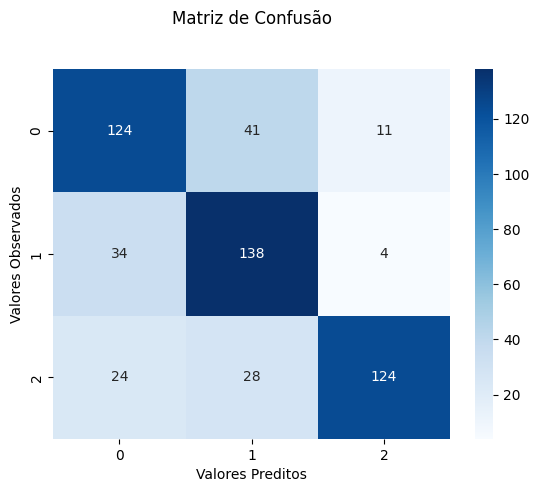

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão', y=1.1)
plt.ylabel('Valores Observados')
plt.xlabel('Valores Preditos');

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_resampled, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       176
           1       0.67      0.78      0.72       176
           2       0.89      0.70      0.79       176

    accuracy                           0.73       528
   macro avg       0.75      0.73      0.73       528
weighted avg       0.75      0.73      0.73       528



Analisando os resultados da classificação do modelo, notamos que o modelo possui uma acurácia considerável, apesar de não tão alta, de 0.73, o que significa que o modelo está acertando 73% dos valores de y. Entre os positivos observados dos patológicos, está acertando 89% dos casos, o que é um valor bem significativo. Já analisando o recall, está acertando só 70% dos verdadeiros positivos da classe 2, então está deixando de acertar 30% dos casos patológicos. O modelo possui um pseudo R² baixo, o que também não é um bom indicativo, significa que o modelo está prevendo só 38% da variabilidade.

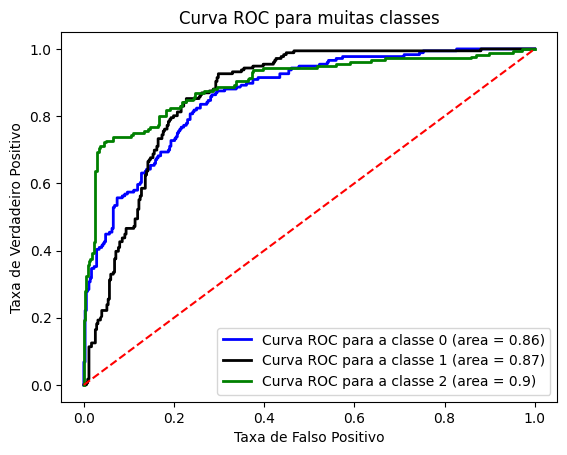

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score, auc

y_cat = label_binarize(y_resampled, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
colors = ['blue','black','green']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_cat[:, i], result.predict(x_result).iloc[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Curva ROC para a classe {i} (area = {round(roc_auc[i], 2)})')

plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC para muitas classes')
plt.legend(loc="lower right");

A curva ROC deu próxima de 1 para as três categorias, o que é um bom indicativo para o modelo.

## Atividade 5: Faça a previsão para um paciente que apresenta as seguintes características:

* `LB` = 121
* `AC` = 0.004176
* `FM` = 0.0
* `UC` = 0.007541
* `DL` = 0.003176
* `DS` = 0.0
* `DP` = 0.0
* `ASTV` = 20
* `mSTV` = 2.3
* `ALTV` = 0
* `mLTV` = 11.5
* `Width` = 129
* `Min` = 54
* `Max` = 171
* `Nmax` = 5
* `Nzeros` = 0
* `Mode` = 140
* `Mean` = 136
* `Median` = 123
* `Variance` = 14
* `Tendency` = 1

In [ ]:
lista = [14, 11.5, 0.004176, 0.0, 0.007541, 0]


In [ ]:
X_prev = pd.DataFrame({'Variance':[14], 'MLTV':[11.5], 'AC':[0.004176], 'FM':[0.0], 'UC':[0.007541], 'ALTV':[0]})
result.predict(X_prev)
y_pred2 = result.predict(X_prev).idxmax(axis=1)[0]
y_pred2

0

In [ ]:
result.predict(lista)

array([[9.68560249e-01, 3.06346625e-02, 8.05088327e-04]])

O resultado indica que o paciente pertence ao grupo 0, ou seja, é um paciente saudável.